[View in Colaboratory](https://colab.research.google.com/github/Zulkhuu/head-gesture-recogniton/blob/master/python/head-pose-estimation/head_pose_train_colab.ipynb)

## Show System Specifications

In [0]:
from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"

print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

Show System RAM Memory:


MemTotal:       13335276 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4590375382869261414
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7258805912688096996
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3659027285657020069
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11276946637
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5648094708007960081
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## Download Dependencies to Google Colab Environment

This may take several minutes but needs to only be run once per session. Every Google Colab session has temporary storage for assets such as images and other scripts. When the session is closed these objects will be removed but the notebook will remain intact.

*Run the cell below to download necessary dependencies. After this is complete you can navigate to the FILES tab on the left and select refresh - you should see the files listed.*


In [56]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

    100% |████████████████████████████████| 993kB 19.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
download = drive.CreateFile({'id': '12zhGg46l-gLp7eZGz_SBXK7eDuN7dyNo'})
download.GetContentFile('HeadPoseImageDatabase_cropped_by_cv_dnn')

In [66]:
!unzip HeadPoseImageDatabase_cropped_by_cv_dnn.zip -d data

unzip:  cannot find or open facial-keypoints-detection.zip, facial-keypoints-detection.zip.zip or facial-keypoints-detection.zip.ZIP.
Archive:  data/training.zip
replace data/training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/training.csv       


# Loading the data 

The data we will use comes from a [Kaggle challenge](https://www.kaggle.com/c/facial-keypoints-detection#description) called *Facial Keypoints Detection*. I've downloaded the *.csv* file and put it in a *facial-keypoints-detection/* directory. Let's use pandas to read it.

In [2]:
import pandas as pd

In [18]:
import_folder = './HeadPoseImageDatabase_cropped_by_cv_dnn'
df = pd.read_csv(import_folder+'/train.csv')

In [19]:
df.head(10)

,tilt,pan,facebox,image
0,0,15,[ 72 78 118 120],Person01/person01147+0+15.jpg
1,30,-90,[157 50 100 114],Person01/person01166+30-90.jpg
2,-60,-30,[204 146 105 108],Person01/person01205-60-30.jpg
3,60,0,[101 27 112 85],Person01/person01185+60+0.jpg
4,30,-15,[121 54 108 112],Person01/person01171+30-15.jpg
5,30,0,[103 54 115 118],Person01/person01172+30+0.jpg
6,-30,60,[ 84 126 105 115],Person01/person01224-30+60.jpg
7,-30,45,[100 120 115 109],Person01/person01223-30+45.jpg
8,60,90,[111 24 112 86],Person01/person01191+60+90.jpg
9,0,60,[ 79 86 105 112],Person01/person01250+0+60.jpg


In [20]:
df.shape

(2534, 4)

# Analyzing the data 

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
def imread(filename):
    """Load image into a numpy array."""
    return cv2.imread('{:s}/{:s}'.format(import_folder,filename),0)

def plot_faces(nrows=5, ncols=5):
    """Randomly displays some faces from the training data."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_files = df.loc[selection]['image']
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for image_file, ax in zip(image_files, axes.ravel()):
        ax.imshow(imread(image_file), cmap='gray')
        ax.axis('off')

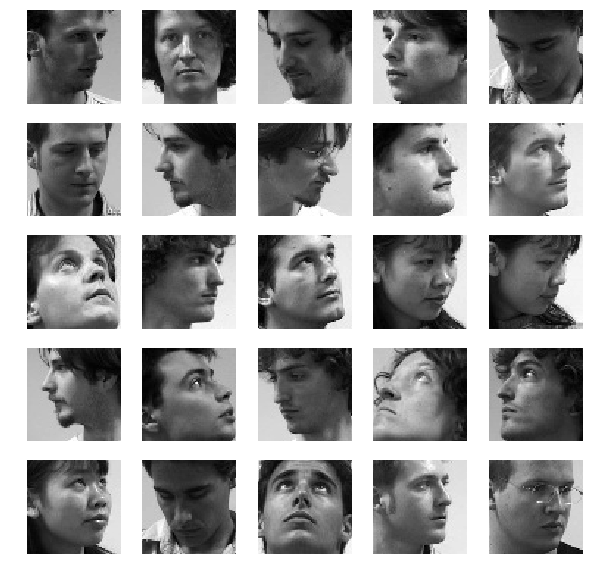

In [47]:
plot_faces()

Let's now add to that plot the facial keypoints that were tagged. First, let's do an example :

In [48]:
pose_cols = list(df.columns)[0:2]

In [49]:
pose = df.iloc[0][pose_cols].values
pose

array([0, 15], dtype=object)

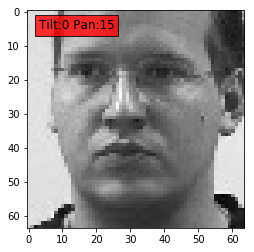

In [64]:
plt.text(3, 5, 'Tilt:{:d} Pan:{:d}'.format(pose[0],pose[1]), fontsize=12,bbox=dict(facecolor='red', alpha=0.8))
plt.imshow(imread(df.iloc[0]['image']), cmap='gray')

Now, let's add this to the function we wrote before.

In [65]:
def plot_faces_with_poses(nrows=5, ncols=5):
    """Randomly displays some faces from the training data with their keypoints."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_files = df.loc[selection]['image']
    pose_cols = list(df.columns)[0:2]
    poses = df.loc[selection][pose_cols]
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for image_file, (iloc, pose), ax in zip(image_files, poses.iterrows(), axes.ravel()):
        ax.imshow(imread(image_file), cmap='gray')
        ax.text(3, 5, 'Tilt:{:d} Pan:{:d}'.format(pose[0],pose[1]), fontsize=12,bbox=dict(facecolor='red', alpha=0.8))
        ax.axis('off')

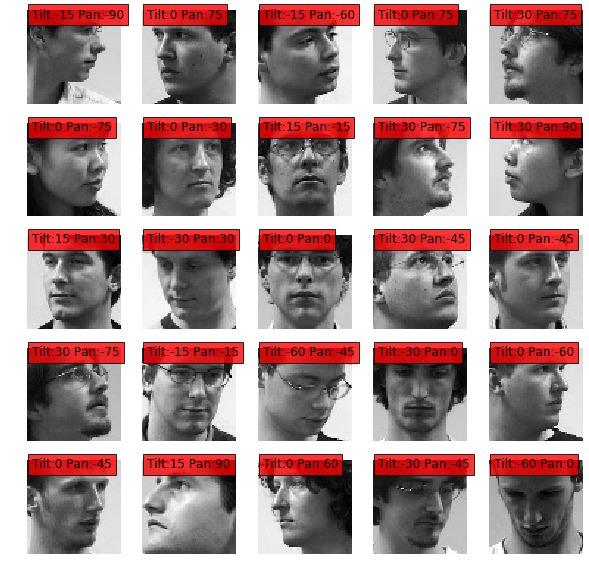

In [67]:
plot_faces_with_poses()

Let's do some statistics about the pose to investigate that last observation :

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f21cd0fc8d0>,
      dtype=object)

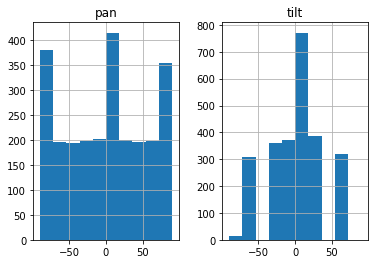

In [75]:
#df.describe().loc['count'].plot.bar()
df.hist()

# Building a Keras model 

Now on to the machine learning part. Let's build a Keras model with our data. Actually, before we do that, let's do some preprocessing first, using the scikit-learn pipelines (inspired by [this great post on scalable Machine Learning by Tom Augspurger](https://tomaugspurger.github.io/scalable-ml-01.html)).

The idea behind pipelining is that it allows you to easily keep track of the data transformations applied to our data. We need two scalings: one for the input and one for the output. Since I couldn't get the scaling to work for 3d image data, we will only use a pipeline for our outputs.

In [76]:
X = np.stack([imread(image_file) for image_file in df['image']]).astype(np.float)[:, :, :, np.newaxis]

In [81]:
y = np.vstack(df[df.columns[0:2]].values)

In [82]:
X.shape, X.dtype

((2534, 64, 64, 1), dtype('float64'))

In [83]:
y.shape, y.dtype

((2534, 2), dtype('int64'))

In [84]:
X_train = X / 255.

In [85]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(y)

ModuleNotFoundError: No module named 'sklearn'

In this case, the pipelining process is, how to say this, not very spectacular. Let's move on and train a Keras model! We will start with a simple model, as found [in this blog post](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) with a fully connected layer and 100 hidden units.

In [89]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D

Using TensorFlow backend.


# Define models 

In [0]:
from keras.layers import Dropout, Flatten

In [100]:
model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(96, 96, 1)))
model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(36, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(48, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 5
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
# layer 6
model.add(Dense(500, activation="relu"))
# layer 7
model.add(Dense(90, activation="relu"))
# layer 8
model.add(Dense(30))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [101]:
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 50
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 4s 3ms/step - loss: 0.0388 - acc: 0.3002 - val_loss: 0.0687 - val_acc: 0.0327
Epoch 2/50
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0354 - acc: 0.3195 - val_loss: 0.0698 - val_acc: 0.0327
Epoch 3/50
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0349 - acc: 0.3102 - val_loss: 0.0699 - val_acc: 0.0327
Epoch 4/50
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0342 - acc: 0.3259 - val_loss: 0.0716 - val_acc: 0.0210
Epoch 5/50
1712/1712 [==============================] - 2s 999us/step - loss: 0.0325 - acc: 0.3172 - val_loss: 0.0670 - val_acc: 0.0327
Epoch 6/50
1712/1712 [==============================] - 2s 999us/step - loss: 0.0295 - acc: 0.3505 - val_loss: 0.0614 - val_acc: 0.0794
Epoch 7/50
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0250 - acc: 0.4136 - val_loss: 0.0551 - val_acc: 0.1028
Epoch 8/50


Let's see that in curves: 

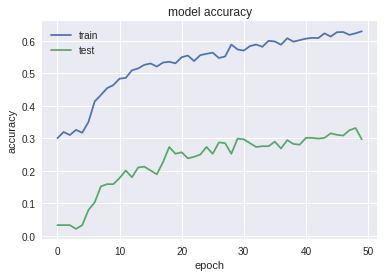

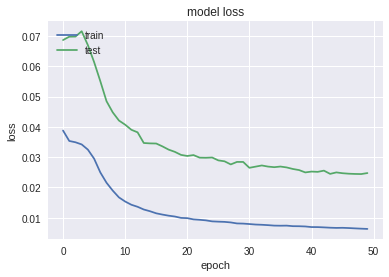

In [102]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

How good is the result?

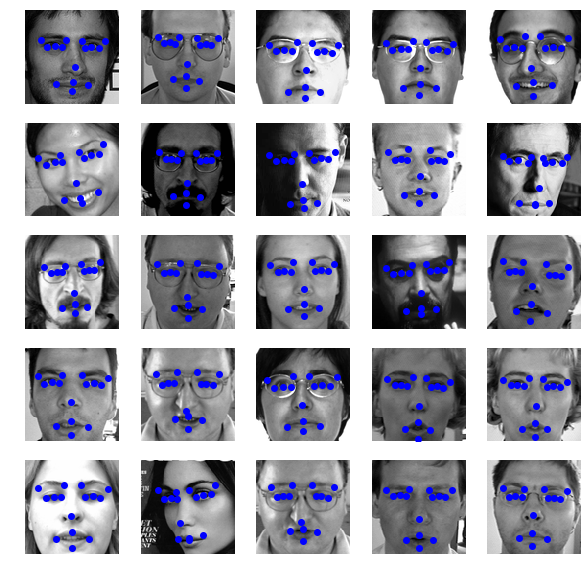

In [103]:
plot_faces_with_keypoints_and_predictions(model, model_input='2d')